# Tests for Energy Drifts

While the system is supposed to be Hamiltonian, it is possible that imprecise numeric calcualtions slowly drift the energy. The goal of this notebook is to check that. 

Processing file: paths9/0.14732219882900877-1.4186704427162562--2.647500614890361--2.475588182492178.csv


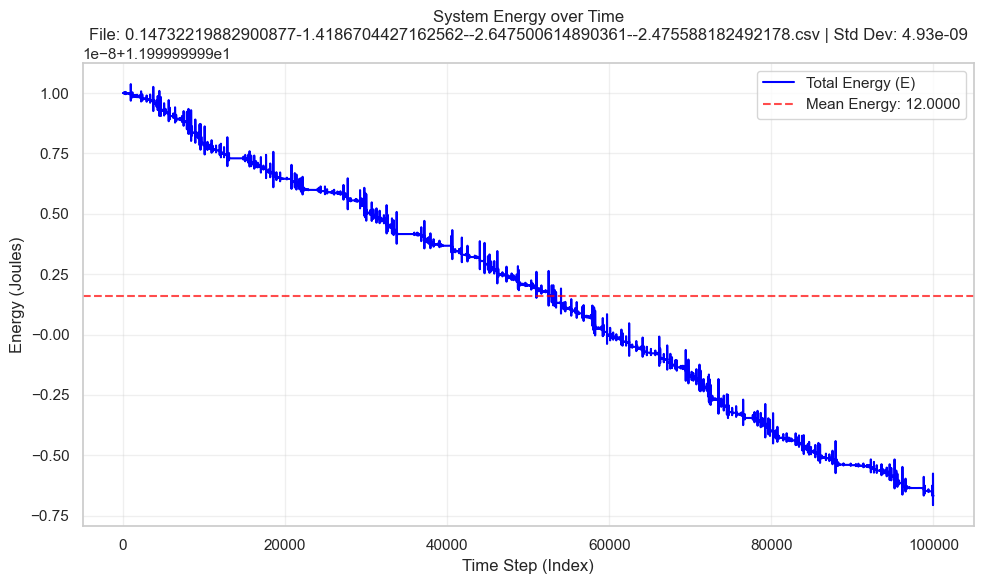

In [49]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class PendulumParams:
    G: float = 9.8
    L1: float = 2.0
    L2: float = 2.0
    M1: float = 1.0
    M2: float = 1.0
    t_stop: float = 1000.0
    dt: float = 0.01

    @property
    def total_length(self) -> float:
        return self.L1 + self.L2

def verify_energy(th1, w1, th2, w2, params: PendulumParams):
    """Function that checks the energy of a pendulum given its state"""
    m1, m2 = params.M1, params.M2
    l1, l2 = params.L1, params.L2
    g = params.G
    M = m1 + m2

    # Potential Energy
    V = -M * g * l1 * np.cos(th1) - m2 * g * l2 * np.cos(th2)

    # Kinetic Energy
    # Derived from Eq (8): 
    # T = 0.5*M*l1^2*w1^2 + 0.5*m2*l2^2*w2^2 + m2*l1*l2*w1*w2*cos(th1-th2)
    T = (0.5 * M * (l1**2) * (w1**2) + 
         0.5 * m2 * (l2**2) * (w2**2) + 
         m2 * l1 * l2 * w1 * w2 * np.cos(th1 - th2))

    E = V + T
    return E, 


search_dir = "paths9"
search_pattern = os.path.join(search_dir, "*.csv")

csv_files = glob.glob(search_pattern)

if not csv_files:
    print(f"Error: No .csv files found in directory '{search_dir}/'")
    # Create a dummy file for demonstration purposes if running in an env without data
    print("Note: Ensure the folder 'paths7' exists and contains CSV files.")

# Pick the first file found
target_file = csv_files[0]
print(f"Processing file: {target_file}")

try:
    # We assume the CSV has headers. If not, remove 'header=0' and use 'names=['theta1'...]
    # Here we assume the column structure is consistent regardless of headers
    df = pd.read_csv(target_file)
    
    # Verify we have enough columns
    if len(df.columns) < 4:
        print(f"Error: File needs at least 4 columns (theta1, w1, theta2, w2). Found: {len(df.columns)}")

    # Map columns by index (0, 1, 2, 3) to ensure robustness even if headers are different
    th1 = df.iloc[:, 0].values
    w1  = df.iloc[:, 1].values
    th2 = df.iloc[:, 2].values
    w2  = df.iloc[:, 3].values

except Exception as e:
    print(f"Error reading CSV: {e}")

# 5. Calculate Energy
total_energy = [verify_energy(df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 2], df.iloc[i, 3], PendulumParams) for i in range(df.shape[0])]

# 6. Plot Results
plt.figure(figsize=(10, 6))

# Plot the Total Energy
plt.plot(total_energy, label='Total Energy (E)', color='blue', linewidth=1.5)

# Calculate statistics for the title
mean_e = np.mean(total_energy)
std_e = np.std(total_energy)

# Add a reference line for the mean energy
plt.axhline(mean_e, color='red', linestyle='--', alpha=0.7, label=f'Mean Energy: {mean_e:.4f}')

plt.title(f"System Energy over Time\nFile: {os.path.basename(target_file)} | Std Dev: {std_e:.2e}")
plt.xlabel("Time Step (Index)")
plt.ylabel("Energy (Joules)")
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust layout and show
plt.tight_layout()
plt.show()

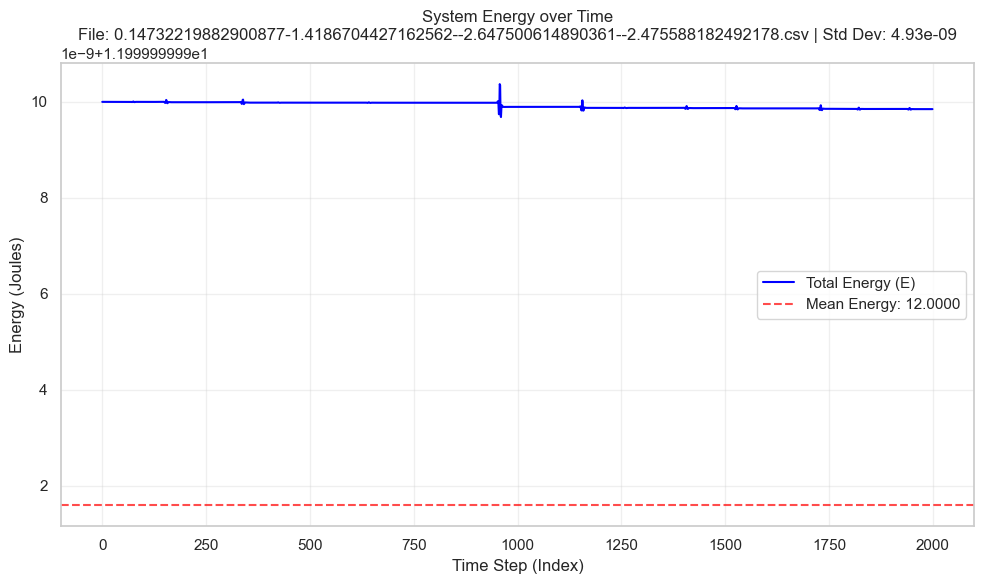

In [50]:
plt.figure(figsize=(10, 6))

# Plot the Total Energy
plt.plot(total_energy[:2000], label='Total Energy (E)', color='blue', linewidth=1.5)

# Calculate statistics for the title
mean_e = np.mean(total_energy)
std_e = np.std(total_energy)

# Add a reference line for the mean energy
plt.axhline(mean_e, color='red', linestyle='--', alpha=0.7, label=f'Mean Energy: {mean_e:.4f}')

plt.title(f"System Energy over Time\nFile: {os.path.basename(target_file)} | Std Dev: {std_e:.2e}")
plt.xlabel("Time Step (Index)")
plt.ylabel("Energy (Joules)")
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust layout and show
plt.tight_layout()
plt.show()

In [51]:
print(th1[0], w1[0], th2[0], w2[0])
print(verify_energy(th1[0], w1[0], th2[0], w2[0], PendulumParams))
print(total_energy[0], total_energy[1])

0.14732219882900877 1.418670442716256 -2.647500614890361 -2.475588182492178
(11.999999999999993,)
(11.999999999999993,) (11.999999999999996,)


In [40]:
verify_energy(2.5681987432718056, 3.4325476169691083, -2.5155190330955457, 2.4395905438988397, PendulumParams)

(120.0,)

## Old Version Below

In [4]:
from double_pendulum_path_gen import *

initial_conditions = generate_initial_conditions(120, 5, PendulumParams)


In [6]:
normalized_state = normalize_init_state(initial_conditions[0])
t, traj = integrate_trajectory(PendulumParams, normalized_state)
angles = traj[:, [0, 2]]
angles = ((angles + np.pi) % (2 * np.pi)) - np.pi  # wrap to [-pi, pi]


In [11]:
print(initial_conditions[0])
print(normalized_state)
print(traj[0])
print(traj[1])

(243.59239013419128, -3.375783501412795, 112.31328682183869, -4.9769686992278865)
(243.59239013419128, -3.375783501412795, 112.31328682183869, -4.9769686992278865)
[ 4.25148924 -0.05891854  1.96023665 -0.08686449]
[ 4.25108475 -0.02198649  1.95926328 -0.10781938]


In [13]:
import numpy as np

def add_energy_column(traj: np.ndarray, params: PendulumParams) -> np.ndarray:
    """
    Given a trajectory array of shape (N, 4) containing
    [theta1, w1, theta2, w2] in radians and radians/sec,
    compute the total mechanical energy at each time point
    and return an array of shape (N, 5) where the last column is energy.
    """

    theta1 = traj[:, 0]
    w1     = traj[:, 1]
    theta2 = traj[:, 2]
    w2     = traj[:, 3]

    m1, m2 = params.M1, params.M2
    l1, l2 = params.L1, params.L2
    g      = params.G

    # --- Kinetic energy ---
    # Velocity of mass 1:
    # v1^2 = (l1*w1)^2
    T1 = 0.5 * m1 * (l1**2) * (w1**2)

    # Velocity of mass 2:
    # v2^2 = (l1*w1)^2 + (l2*w2)^2 + 2*l1*l2*w1*w2*cos(theta1 - theta2)
    T2 = 0.5 * m2 * (
        (l1**2)*(w1**2)
        + (l2**2)*(w2**2)
        + 2*l1*l2*w1*w2*np.cos(theta1 - theta2)
    )

    # --- Potential energy ---
    # y1 = -l1*cos(theta1)
    # y2 = y1 - l2*cos(theta2)
    # V = m*g*y
    V1 = m1 * g * (-l1 * np.cos(theta1))
    V2 = m2 * g * (-l1 * np.cos(theta1) - l2 * np.cos(theta2))

    # Total energy = kinetic + potential
    E = T1 + T2 + V1 + V2

    # Append as a new column
    traj_with_energy = np.hstack([traj, E[:, None]])
    return traj_with_energy

traj_energy = add_energy_column(traj, PendulumParams)

print(traj_energy.shape)   # (N, 5)
print(traj_energy[0])      # [theta1, w1, theta2, w2, E]

(100002, 5)
[ 4.25148924 -0.05891854  1.96023665 -0.08686449 24.89137884]


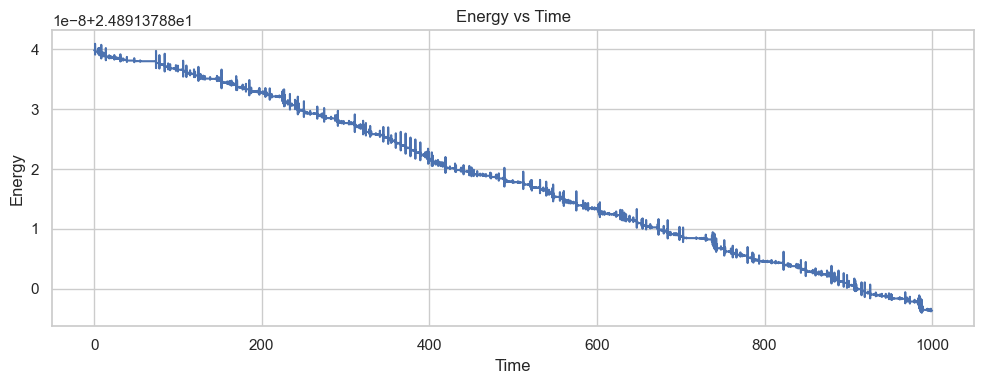

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.set(style="whitegrid")

energy = traj_energy[:, 4]

plt.figure(figsize=(10, 4))
sns.lineplot(x=t, y=energy)

plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy vs Time")
plt.tight_layout()
plt.show()
